# ! rdkit+mordred

In [1]:
!python --version

Python 3.7.10


In [2]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
import matplotlib.pyplot as plt


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdchem
from rdkit.Chem import Draw
from tqdm.notebook import tqdm

import re

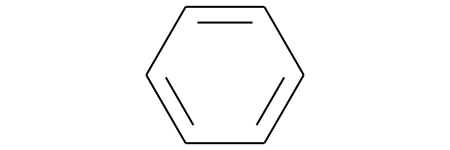

In [4]:
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('c1ccccc1')

In [5]:
!pip install mordred

# feature.py

In [6]:
from rdkit import Chem
import numpy as np
import pandas as pd
import pickle
from mordred import Calculator, descriptors

# Credit: http://www.dna.bio.keio.ac.jp/smiles/

# xp = np

#
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

 # featurevector
atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

#
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

#
upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

#
def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]

    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)

def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)

def calc_featurevector(mol, smiles, atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def isomer_smiles(mol,n):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return isomerSMILES


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES, atomsize)


def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES, atomsize))
        idx = idx + 1
    return(features)


def atom_flag(smiles,atomsize):
    flag=[]
    j = 0
            
    for c in smiles:
        if islower(c) == True: 
            if c in ['c', 'n', 's', 'o']:
                flag.append(1)
            else:
                flag.append(0)
        elif isupper(c) == True:
            if c in ['H',]:
                flag.append(0)
            else:
                flag.append(1)
        else:   
            flag.append(0)           

    #0-Padding
    flag.extend([0]*(atomsize-len(smiles)))        
    return(flag)

# import ViralChEMBL

In [7]:
#Get ViralChEMBL_dataset
#https://drive.google.com/file/d/1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu/view?usp=sharing
!gdown --id "1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu"

!unzip -q ViralChEMBL_dataset.zip && rm ViralChEMBL_dataset.zip

db = pd.read_csv('/content/ViralChEMBL_dataset.csv')

Downloading...
From: https://drive.google.com/uc?id=1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu
To: /content/ViralChEMBL_dataset.zip
22.0MB [00:00, 60.3MB/s]
replace ViralChEMBL_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
db.head(10)

,activity_id,standard_type,standard_relation,standard_value,standard_units,av_value,av_units,av_act50,assay_chembl_id,description,assay_type,findec_a,mapping_conf,stdstr_id,molregno,canonical_smiles,std_smiles,species_id,species_name,path_flag,genus_name,subfamily_name,family_name,order_name
0,147811,CC50,=,1000000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397206,1633264,CC1=CN([C@H]2C[C@H](O[N+](=O)[O-])[C@@H](CO)O2...,CC1=CN([C@H]2C[C@H](O[N+]([O-])=O)[C@@H](CO)O2...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
1,158768,CC50,=,200000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397576,1633676,NC1=NC(=O)N(C=C1)[C@H]2C[C@H](O[N+](=O)[O-])[C...,NC1=NC(=O)N(C=C1)[C@H]1C[C@H](O[N+]([O-])=O)[C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
2,161153,CC50,=,700000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,166147,556,[O-][N+](=O)O[C@H]1CO[C@@H]2[C@@H](CO[C@H]12)O...,[O-][N+](=O)O[C@@H]1CO[C@@H]2[C@H](CO[C@H]12)O...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
3,162405,CC50,=,100000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,230956,82983,OC[C@H]1O[C@H](C[C@@H]1O)N2C=C(F)C(=O)NC2=O,OC[C@H]1O[C@H](C[C@@H]1O)N1C=C(F)C(=O)NC1=O,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
4,164805,CC50,=,21000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397165,1633207,O[C@H]1C[C@@H](O[C@@H]1CO[N+](=O)[O-])N2C=C(I)...,O[C@H]1C[C@@H](O[C@@H]1CO[N+]([O-])=O)N1C=C(I)...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
5,166047,CC50,=,74000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397575,1633675,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=C(F)C...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=C(F)C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
6,166058,CC50,=,7400000.0,nM,NaN,NaN,NaN,CHEMBL615126,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,203297,47675,OC[C@H]1O[C@H](C[C@@H]1O)N2C=C(I)C(=O)NC2=O,OC[C@H]1O[C@H](C[C@@H]1O)N1C=C(I)C(=O)NC1=O,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
7,151529,CC50,=,850000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397164,1633206,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=CC(=O...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=CC(=O...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
8,158813,CC50,=,200000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397210,1633268,NC1=NC(=O)N(C=C1I)[C@H]2C[C@H](O[N+](=O)[O-])[...,NC1=NC(=O)N(C=C1I)[C@H]1C[C@H](O[N+]([O-])=O)[...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales
9,161189,CC50,=,410000.0,nM,NaN,NaN,NaN,CHEMBL615127,In vitro cell cytotoxicity against 143B-LTK ce...,F,480,1,1397552,1633652,OC[C@H]1O[C@H](C[C@@H]1O[N+](=O)[O-])N2C=C(I)C...,OC[C@H]1O[C@H](C[C@@H]1O[N+]([O-])=O)N1C=C(I)C...,480.0,Human herpesvirus 1,1.0,Simplexvirus,Alphaherpesvirinae,Herpesviridae,Herpesvirales


In [9]:
id1 = 2938 #HIV1
id2 = 1620 #HCV

In [10]:
ds1 = db[(db.species_id == id1) & (db.av_act50==1)]

In [11]:
ds2 = db[(db.species_id == id2) & (db.av_act50==1)]

In [12]:
import matplotlib
from matplotlib_venn import venn2, venn2_circles

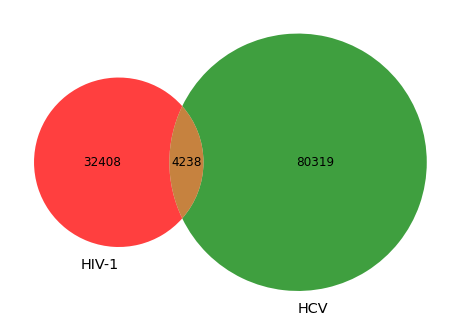

In [13]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(8,8))
out = venn2([set(ds1.canonical_smiles.values), set(ds2.canonical_smiles.values)], 
      # set_colors=('#3E64AF', '#3EAF5D'), 
      set_labels = ('HIV-1', 
                    'HCV'),
      alpha=0.75)
plt.show()

# Create a DS

In [14]:
ds_full = pd.DataFrame()

ds_full = pd.concat([ds1[['canonical_smiles', 'species_id']].drop_duplicates(),
                      ds2[['canonical_smiles', 'species_id']].drop_duplicates()])

In [15]:
ds_full = ds_full.drop_duplicates(subset=['canonical_smiles'], keep=False)

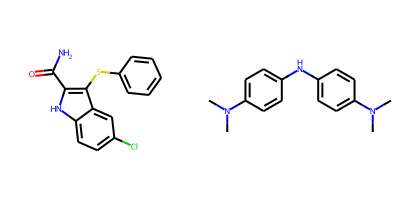

In [16]:
smiles_list = [ds_full[ds_full['species_id']==id1][:1]['canonical_smiles'].item(), ds_full[ds_full['species_id']==id2][:1]['canonical_smiles'].item()]
mol_list = []
for smiles in smiles_list:
	mol = Chem.MolFromSmiles(smiles)
	mol_list.append(mol)

img = Draw.MolsToGridImage(mol_list, molsPerRow=len(mol_list), useSVG=True)
img

In [17]:
MAX_LEN_selected = 250

In [18]:
ds_full = ds_full[ds_full.canonical_smiles.apply(len) <= MAX_LEN_selected]

In [19]:
# get mord keys from the baseline paper
!gdown --id 16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8

Downloading...
From: https://drive.google.com/uc?id=16S-QJGH0vWtmhB0ONF0cFyyoNmObusd8
To: /content/mord_keys.csv
100% 6.21k/6.21k [00:00<00:00, 2.54MB/s]


In [20]:
custom_descriptors = pd.read_csv('mord_keys.csv')['mord_keys'].values.tolist()

In [21]:
MAX_LEN = ds_full['canonical_smiles'].map(lambda x: len(str(x))).max()
MAX_LEN

250

In [22]:
get_smaller_version = ds_full.sample(frac=0.005)

In [23]:
get_smaller_version.species_id.value_counts()

1620.0    391
2938.0    170
Name: species_id, dtype: int64

In [24]:
MAX_LEN = get_smaller_version['canonical_smiles'].map(lambda x: len(str(x))).max()
MAX_LEN

226

In [25]:
mols = [Chem.MolFromSmiles(i) for i in get_smaller_version.canonical_smiles.to_list()]
calc = Calculator(descriptors, ignore_3D=True)

In [26]:
iso_smiles = [isomer_smiles(mol,-1) for mol in mols]

In [27]:
MAX_LEN = max([len(x) for x in iso_smiles])
MAX_LEN

280

In [28]:
md = calc.pandas(mols)

 22%|██▏       | 122/561 [00:55<05:42,  1.28it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 29%|██▊       | 161/561 [01:14<05:55,  1.13it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 34%|███▎      | 188/561 [01:26<04:19,  1.44it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 561/561 [04:18<00:00,  2.17it/s]


In [29]:
smile_ft = [mol_to_feature(mol,-1, MAX_LEN) for mol in mols]

In [30]:
md = md[custom_descriptors]

In [31]:
md['active'] = get_smaller_version.species_id.apply(lambda x: 1 if x == id1 else 0).values.tolist()
md['smile_ft'] = smile_ft
md['smiles'] = get_smaller_version.canonical_smiles.values.tolist()
md['iso_smiles'] = iso_smiles

In [32]:
set([len(x) for x in smile_ft])

{11760}

In [33]:
from collections import Counter
Counter([len(x) for x in smile_ft])

Counter({11760: 561})

In [34]:
md.to_csv('/content/small_hiv1_hcv.csv')